#### Copyright 2019 The TensorFlow Authors.

In [65]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [66]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler




import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif
import numpy as np
from scipy import stats as st
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer

In [67]:
import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.set_option('display.max_columns', None)

## Data processing and exploration

In [68]:
df = pd.read_excel(r"data/trainDataset.xls")
df.head(5)

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1,144.0,41.0,0,0,0,1,3,3,1,1,2,0.813912,0.724080,23.781937,32.844370,37.696154,38.626416,34.713110,39.572718,14209.458330,26.732440,0.771675,3676.500012,0.258736,14263,-0.163500,0.708860,2897.68930,0.738088,0.406537,4.594629,2.114799,0.278008,0.248168,0.217628,-1.251833,3.366632,0.174026,0.450734,0.386237,2897.68930,0.670

In [69]:
df = df[df['pCR (outcome)'] != 999]

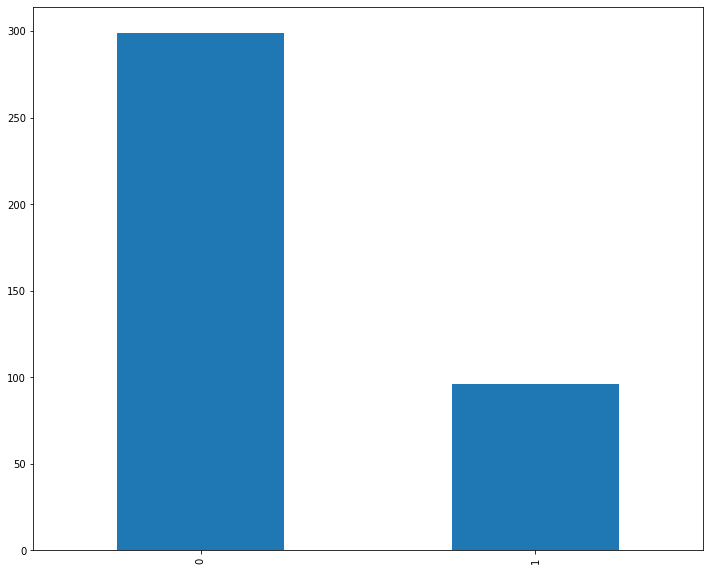

In [70]:
df['pCR (outcome)'].value_counts().plot(kind='bar')
plt.show()

### Transform Numerical data

In [71]:
float_cols = list(df.select_dtypes(include='float64').columns)
cat_cols = list(df.select_dtypes(include='int64').columns)
cat_cols.remove('original_shape_VoxelVolume')
cat_cols.remove('pCR (outcome)')
float_cols.append('original_shape_VoxelVolume')
float_cols.remove('RelapseFreeSurvival (outcome)')
df_floats = df[float_cols]
df_cats = df[cat_cols]

### Remove outliers

In [72]:
def find_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)
    return lower_boundary, upper_boundary

def treat_outliers(df, variable, distance=1.5, inplace=True):
    """ 
    Fill outliers with mean
    
    upper_boundary = 75th qualtile + (IQR * diatance)
    upper_boundary = 25th qualtile - (IQR * diatance)
        
    """
    
    lower_boundary, upper_boundary = find_boundaries(df,variable)
    if inplace:
        df[variable] = np.where(df[variable]>upper_boundary,df[variable].mean(),
                                np.where(df[variable]<lower_boundary,df[variable].mean(),df[variable])
                           )
    else:
        return np.where(df[variable]>upper_boundary,df[variable].mean(),
                                np.where(df[variable]<lower_boundary,df[variable].mean(),df[variable])
                           )

In [73]:
for col in float_cols:
    treat_outliers(df_floats, col, inplace=True)

### Merging floats and cats

In [74]:
X = pd.concat([df_cats.reset_index(drop=True),df_floats.reset_index(drop=True)],axis=1)
y = df['pCR (outcome)']

### Splitting the data

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

### Imputing missing values

In [76]:
sif = SimpleImputer(missing_values=999, strategy='mean')
sic = SimpleImputer(missing_values=999, strategy='median')

In [77]:
#Imputing values for continuous data
sic.fit(X_train[cat_cols])
sif.fit(X_train[float_cols])

X_train_cats = pd.DataFrame(sic.transform(X_train[cat_cols]),columns=cat_cols)
X_train_floats = pd.DataFrame(sif.transform(X_train[float_cols]),columns=float_cols)

X_train = pd.concat([X_train_cats.reset_index(drop=True),X_train_floats.reset_index(drop=True)],axis=1)

X_test_cats = pd.DataFrame(sic.transform(X_test[cat_cols]),columns=cat_cols)
X_test_floats = pd.DataFrame(sif.transform(X_test[float_cols]),columns=float_cols)

X_test = pd.concat([X_test_cats.reset_index(drop=True),X_test_floats.reset_index(drop=True)],axis=1)

### Normalization

In [79]:
transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(X_train[float_cols])
X_train_floats = pd.DataFrame(transformer.transform(X_train[float_cols]),columns=float_cols)
X_test_floats = pd.DataFrame(transformer.transform(X_test[float_cols]),columns=float_cols)

X_train_cats = X_train[cat_cols]
X_test_cats = X_test[cat_cols]

X_train = pd.concat([X_train_cats.reset_index(drop=True),X_train_floats.reset_index(drop=True)],axis=1)
X_test = pd.concat([X_test_cats.reset_index(drop=True),X_test_floats.reset_index(drop=True)],axis=1)

### Scaling the data

In [81]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

## Applyting Neural Netwrok

In [83]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [84]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    """
    if metric == 'loss':
      #plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    """

    plt.legend()

In [85]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


In [86]:
## Run the model with training data and generate metrics on test data

def experiment(model, EPOCHS = 100, PATIENCE=10, lr = 1e-3 ,class_weight={0:1, 1:1}):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=PATIENCE,
    mode='max',
    restore_best_weights=True)
    
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS
        )
    baseline_history = model.fit( X_train, y_train, epochs=EPOCHS,callbacks=[early_stopping],
                                 validation_data=(X_test, y_test), verbose=0,
                                 class_weight=class_weight
                                )
    plot_metrics(baseline_history)
    
    test_predictions_baseline = model.predict(X_test)
    
    baseline_results = model.evaluate(X_test, y_test, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)
        print()
        
    plot_cm(y_test, test_predictions_baseline)
    

In [87]:
## Run the model with training synthetic data and generate metrics on test data
def experimentSD(model, EPOCHS = 100, PATIENCE=10, lr = 1e-3 ):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=PATIENCE,
    mode='max',
    restore_best_weights=True)
    
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS
        )
    baseline_history = model.fit( X_res, y_res, epochs=EPOCHS,callbacks=[early_stopping],
                                 validation_data=(X_test, y_test), verbose=0
                                )
    plot_metrics(baseline_history)
    
    test_predictions_baseline = model.predict(X_test)
    
    baseline_results = model.evaluate(X_test, y_test, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)
        print()
        
    plot_cm(y_test, test_predictions_baseline)
    

### Experiment 1

Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping
4/4 [==============================] - 0s 8ms/step
loss :  0.6530866622924805

tp :  9.0

fp :  18.0

tn :  57.0

fn :  15.0

accuracy :  0.6666666865348816

precision :  0.3333333432674408

recall :  0.375

auc :  0.6116666793823242

prc :  0.3539774417877197



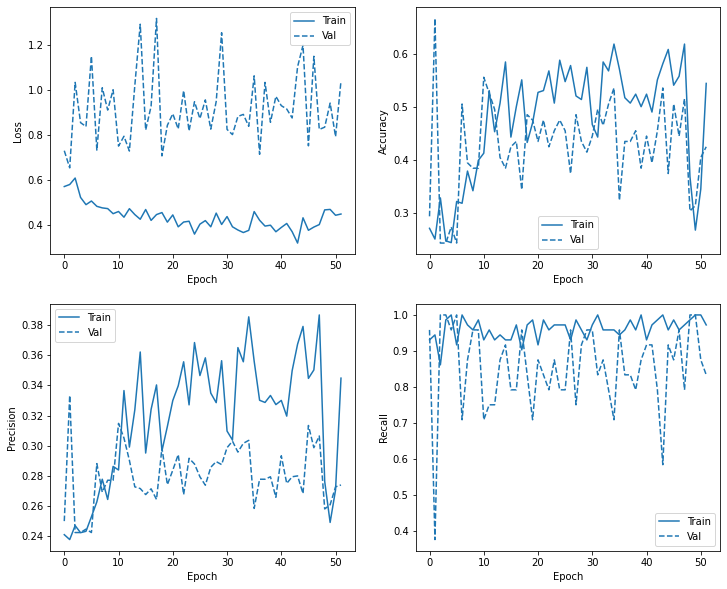

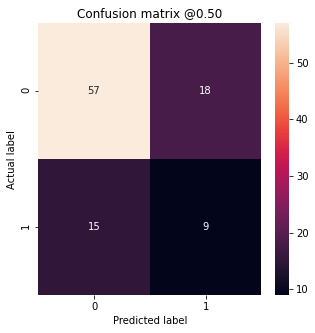

In [88]:
model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(800, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(900, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(500, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(200, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model, EPOCHS = 100, PATIENCE=50, lr = 1e-3, class_weight={0:0.3, 1:2.9})

### Experiment 2

Restoring model weights from the end of the best epoch: 17.
Epoch 117: early stopping
4/4 [==============================] - 0s 4ms/step
loss :  0.5697473883628845

tp :  3.0

fp :  1.0

tn :  74.0

fn :  21.0

accuracy :  0.7777777910232544

precision :  0.75

recall :  0.125

auc :  0.5836110711097717

prc :  0.32583028078079224



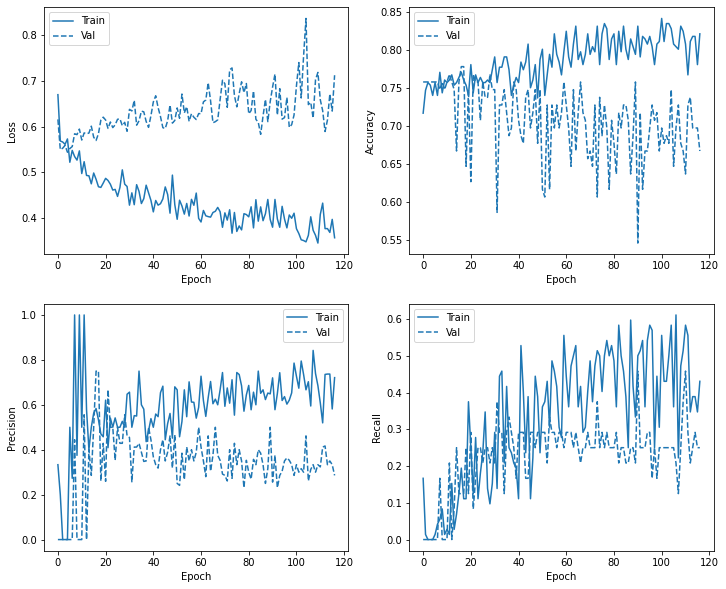

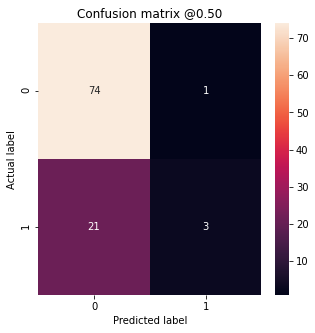

In [104]:
model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(800, activation='relu'),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(900, activation='relu'),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(500, activation='relu'),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(200, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model, EPOCHS = 300, PATIENCE=100, lr = 1e-2)

### Experiment 3

Restoring model weights from the end of the best epoch: 37.
Epoch 137: early stopping
4/4 [==============================] - 0s 2ms/step
loss :  0.5848390460014343

tp :  3.0

fp :  0.0

tn :  75.0

fn :  21.0

accuracy :  0.7878788113594055

precision :  1.0

recall :  0.125

auc :  0.6008333563804626

prc :  0.40914034843444824



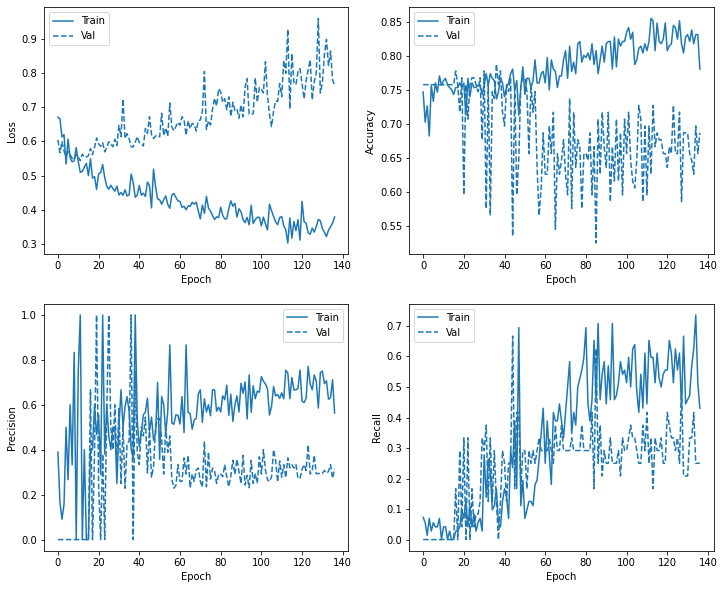

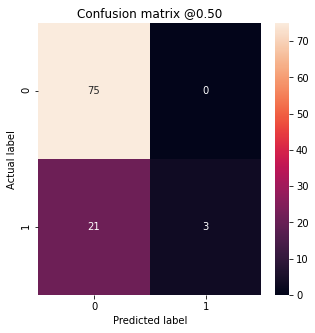

In [90]:
model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(800, activation='relu'),
      keras.layers.Dropout(0.7),
      keras.layers.Dense(900, activation='relu'),
      keras.layers.Dropout(0.7),
      keras.layers.Dense(500, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(200, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 300, PATIENCE=100, lr = 1e-4)

### Experiment 4

Restoring model weights from the end of the best epoch: 74.
Epoch 174: early stopping
4/4 [==============================] - 0s 3ms/step
loss :  1.2259690761566162

tp :  10.0

fp :  7.0

tn :  68.0

fn :  14.0

accuracy :  0.7878788113594055

precision :  0.5882353186607361

recall :  0.4166666567325592

auc :  0.6811110973358154

prc :  0.43589308857917786



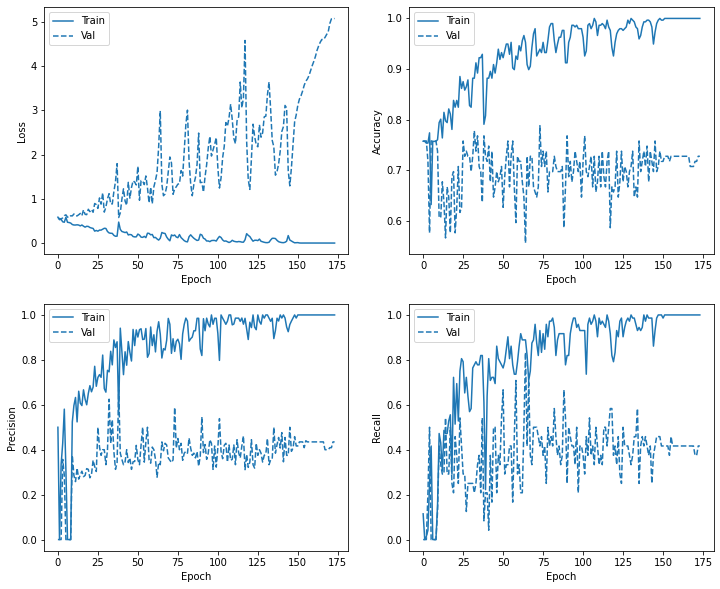

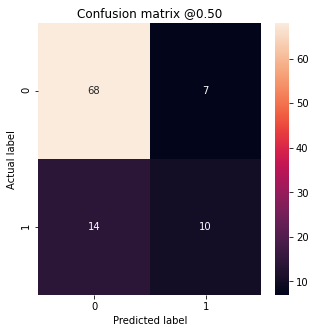

In [92]:
model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),      
      keras.layers.Dense(800, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(900, activation='relu'),      
      keras.layers.Dense(500, activation='relu'),      
      keras.layers.Dense(200, activation='relu'),      
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 300, PATIENCE=100, lr = 1e-3)

### Experiment 5 --- Best

Restoring model weights from the end of the best epoch: 54.
Epoch 154: early stopping
4/4 [==============================] - 0s 0s/step
loss :  1.0176600217819214

tp :  5.0

fp :  3.0

tn :  72.0

fn :  19.0

accuracy :  0.7777777910232544

precision :  0.625

recall :  0.2083333283662796

auc :  0.6305555105209351

prc :  0.37875086069107056



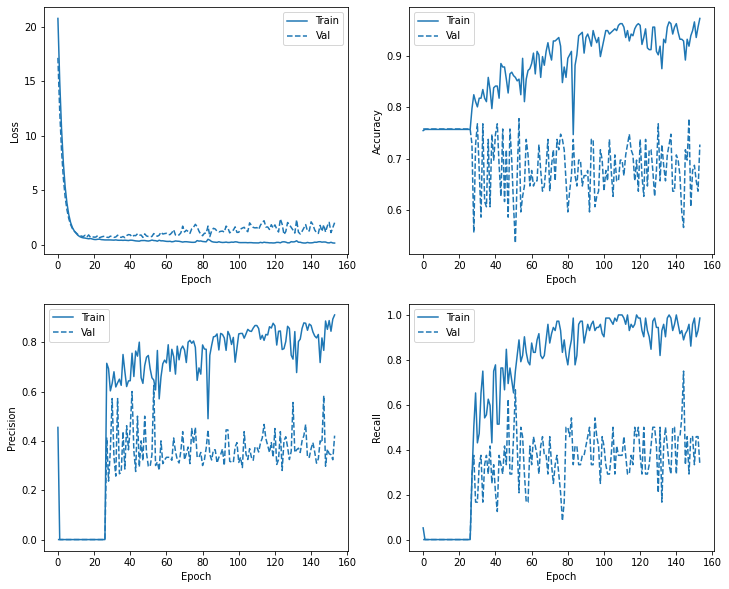

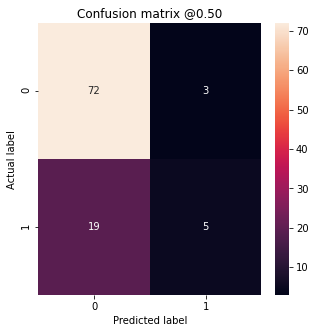

In [108]:
model = keras.Sequential([
      keras.layers.Dense(170, activation='relu',input_shape=(X_train.shape[-1],)),    
      keras.layers.Dense(units = 240, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 320, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 480, activation = 'relu'),  
      keras.layers.Dropout(0.1),
      keras.layers.Dense(units = 560, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 240, activation = 'relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(units = 120, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 24, activation = 'relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 500, PATIENCE=100, lr = 1e-4)

### Adding synthetic data

- Used SMOTE to upsmaple the minority class

In [169]:
sm = SMOTE(random_state=42,k_neighbors=3)

X_res, y_res = sm.fit_resample(X_train, y_train)

Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping
4/4 [==============================] - 0s 0s/step
loss :  17.28571128845215

tp :  6.0

fp :  0.0

tn :  74.0

fn :  18.0

accuracy :  0.8163265585899353

precision :  1.0

recall :  0.25

auc :  0.7317004799842834

prc :  0.5492756366729736

Legitimate Transactions Detected (True Negatives):  74
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  18
Fraudulent Transactions Detected (True Positives):  6
Total Fraudulent Transactions:  24


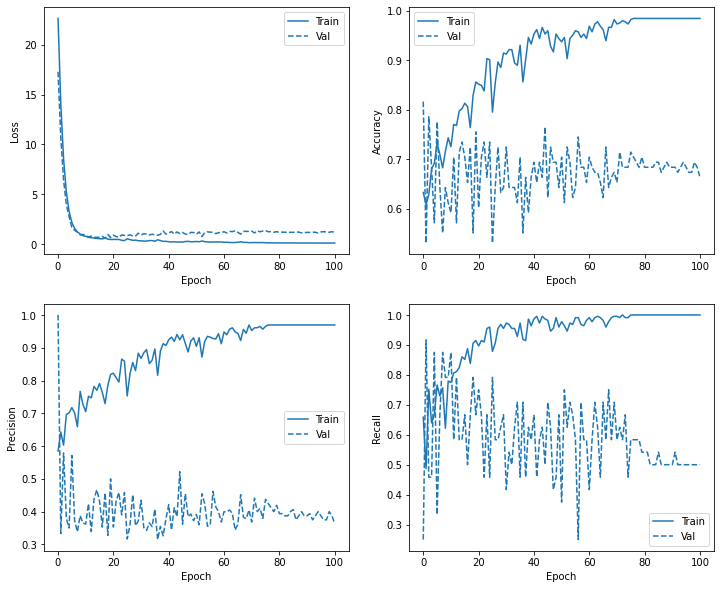

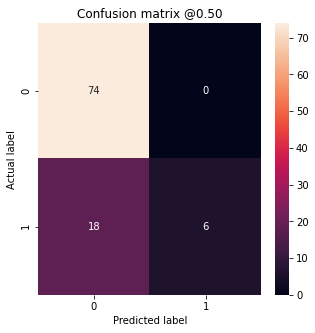

In [181]:
model = keras.Sequential([
      keras.layers.Dense(170, activation='relu',input_shape=(X_train.shape[-1],)),    
      keras.layers.Dense(units = 240, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 320, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.025)),  
      keras.layers.Dense(units = 480, activation = 'relu'),  
      keras.layers.Dense(units = 560, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.025)),  
      keras.layers.Dense(units = 240, activation = 'relu'),
      keras.layers.Dense(units = 120, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 24, activation = 'relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experimentSD(model,EPOCHS = 500, PATIENCE=100, lr = 1e-4)

In [180]:
model.save('saved_model/best_model_aucc82')

INFO:tensorflow:Assets written to: saved_model/best_model_aucc82\assets


### Functional API Experiments

Restoring model weights from the end of the best epoch: 41.
Epoch 141: early stopping
4/4 [==============================] - 0s 4ms/step
loss :  1.0308938026428223

tp :  5.0

fp :  3.0

tn :  72.0

fn :  19.0

accuracy :  0.7777777910232544

precision :  0.625

recall :  0.2083333283662796

auc :  0.5688889026641846

prc :  0.3409537672996521

Legitimate Transactions Detected (True Negatives):  72
Legitimate Transactions Incorrectly Detected (False Positives):  3
Fraudulent Transactions Missed (False Negatives):  19
Fraudulent Transactions Detected (True Positives):  5
Total Fraudulent Transactions:  24


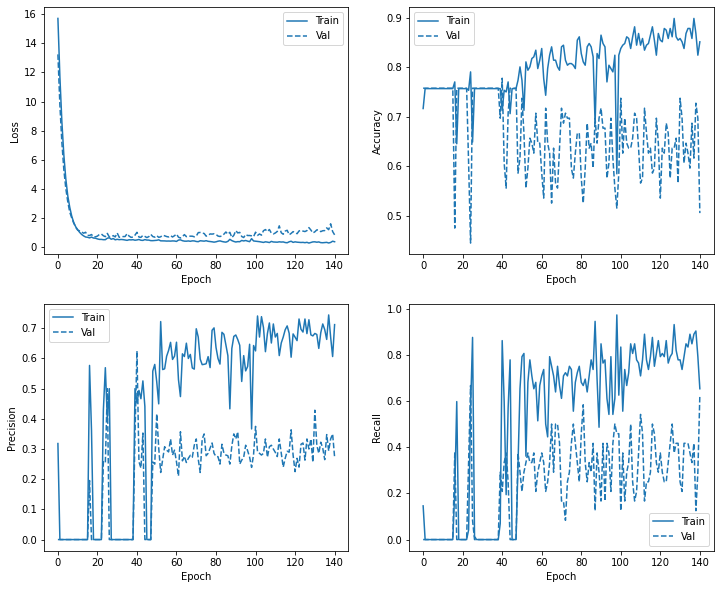

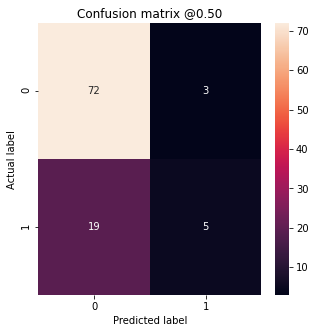

In [95]:
inputs = keras.Input(shape=(X_train.shape[1]))
x = keras.layers.Dense(units = 240, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02))(inputs)
x = keras.layers.Dense(units = 320, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02))(x)
x = keras.layers.Dense(units = 480, activation = 'relu')(x)
x = keras.layers.Dense(units = 560, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.01))(x)
int_features = keras.layers.Dense(units = 240, activation = 'relu')(x)
x = keras.layers.Dense(units = 120, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02))(int_features)
x = keras.layers.Dense(units = 24, activation = 'relu')(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

x = keras.layers.concatenate([int_features,x])
x = keras.layers.Dense(units = 480, activation = 'relu')(x)
x = keras.layers.Dense(units = 360, activation = 'relu')(x)
x = keras.layers.Dense(units = 120, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs, name="functionalAPI_model")


experiment(model,EPOCHS = 500, PATIENCE=100, lr = 1e-4)

### Saving all Modle objects to run on the test data

In [ ]:
##Saving the model
#model.save('saved_model/best_model_aucc82')

In [107]:
import pickle

# save the imputer to disk
filename = 'saved_model/float_cols_imputer.sav'
pickle.dump(sif, open(filename, 'wb'))

filename = 'saved_model/int_cols_imputer.sav'
pickle.dump(sic, open(filename, 'wb'))

# save the transformer to disk
filename = 'saved_model/trnsformer.sav'
pickle.dump(transformer, open(filename, 'wb'))


# save the scaler to disk
filename = 'saved_model/scaler.sav'
pickle.dump(scaler, open(filename, 'wb'))

# Continuous columns list
filename = 'saved_model/continuous_features.pkl'
pickle.dump({'continuous_features':float_cols}, open(filename, 'wb'))

# Categorical columns
filename = 'saved_model/categorical_features.pkl'
pickle.dump({'categorical_features':cat_cols}, open(filename, 'wb'))
